In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from ast import literal_eval

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})

def load_and_prepare_results(dataset_name, suffix="features", lookahead=None, folds=None,
                             c_value=None, methods=None, remove_failed_runs=True, print_counts=True, 
                             combine_c_and_method=True, combine_opt_and_method=True, opt_crits=None,
                             scoreset_size=None):
    df = pd.read_csv(f"./results/results_{dataset_name}_{suffix}.csv")
    if remove_failed_runs and "exception" in df:
        df = df[df.exception.isna()]
    if c_value:
        df = df[df.c_value==c_value]
    if lookahead:
        df = df[df.lookahead==lookahead]
    if methods:
        df = df[df.method.isin(methods)]
    if opt_crits:
        df = df[df.psl_optimization_metric.isin(opt_crits)]
    match folds:
        case int():
            df = df[df.fold<folds]
        case list():
            df = df[df.fold.isin(folds)]
        case _:
            pass
    if "c_value" in df.columns and combine_c_and_method:
        df["c_value"] = df["c_value"].fillna(" ")
        df["method"] = df["method"] + " " + df["c_value"].astype("str")
    if combine_opt_and_method:
        df["psl_optimization_metric"] = df["psl_optimization_metric"].fillna(" ")
        df["method"] = df["method"] + " " + df["psl_optimization_metric"].astype("str")
    df["lookahead"] = df["lookahead"].astype("str")
    df["score_set"] = df["score_set"].apply(literal_eval)
    df["score_set_size"] = df["score_set"].apply(len) 
    if scoreset_size:
        df =  df[df["score_set_size"] == scoreset_size]
    
    return df

def update_axes_tuple(axes, metric):
    axes[0].set_ylabel(f"{metric} in sample")
    axes[1].set_ylabel(f"{metric} out of sample")

    for ax in axes:
        ax.xaxis.set_major_locator(MaxNLocator(nbins="auto",steps=[1,2,3,5]))
        ax.set_xlabel("")
        if legend := ax.get_legend():
            legend.remove()
    
    axes[0].tick_params('y', labelleft=False, labelright=True)
    axes[1].tick_params('y', labelleft=False, labelright=False)
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.get_label().set_visible(True)

# Feature Experiments
This section contains results from experiments with the number of features as a degree of complexity

In [5]:
datasets = [ "thorax", "covid", "adult", "breast", "heart"]
df = load_and_prepare_results(datasets[0])
display(set(df.psl_optimization_metric))
hue_order_train = ['expected_entropy_train','constrained_precision_train',  'accuracy_score_y_pred_train', 'balanced_accuracy_score_y_bal_train', 'f1_score_y_pred_train']
hue_order_test = [l.replace("_train", "_test") for l in hue_order_train]
display(df.columns)
cp = "Precision@0.9"

{' ',
 'accuracy',
 'balanced_accuracy',
 'constrained_precision',
 'expected_entropy'}

Index(['dataset', 'fold', 'score_set', 'method', 'c_value', 'stage',
       'features', 'scores', 'slim_threshold', 'solution_code',
       'accuracy_score_y_pred_train', 'accuracy_score_y_pred_test',
       'balanced_accuracy_score_y_pred_train',
       'balanced_accuracy_score_y_pred_test', 'precision_score_y_pred_train',
       'precision_score_y_pred_test', 'recall_score_y_pred_train',
       'recall_score_y_pred_test', 'f1_score_y_pred_train',
       'f1_score_y_pred_test', 'lookahead', 'psl_calibration_method',
       'psl_optimization_metric', 'brier_score_loss_train',
       'brier_score_loss_test', 'roc_auc_score_train', 'roc_auc_score_test',
       'constrained_precision_train', 'constrained_precision_test',
       'expected_entropy_train', 'expected_entropy_test',
       'accuracy_score_y_bal_train', 'accuracy_score_y_bal_test',
       'accuracy_score_cp_train', 'accuracy_score_cp_test',
       'balanced_accuracy_score_y_bal_train',
       'balanced_accuracy_score_y_bal_test

# Validation: Optimization Criterion of Slim and PSL equal (accuracy), how similar is performance

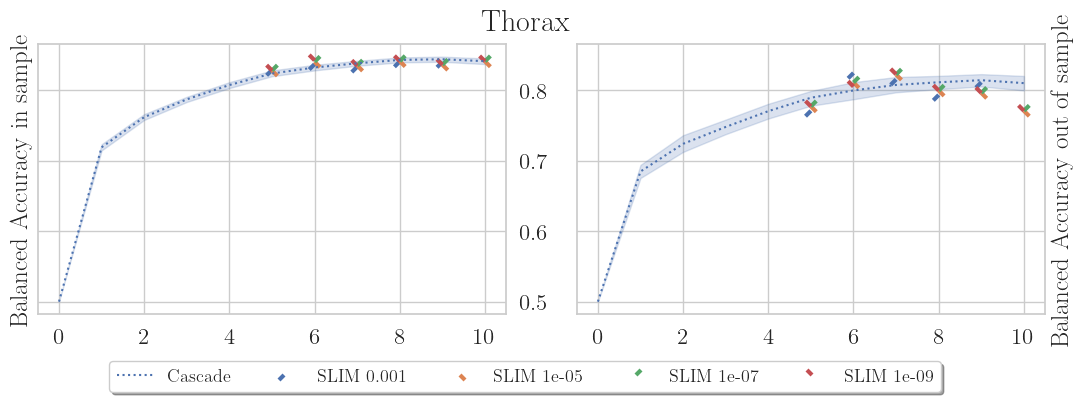

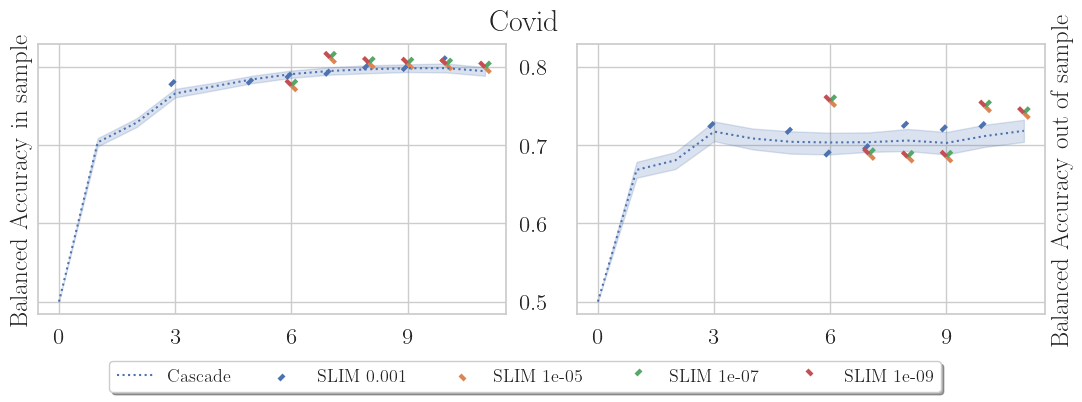

In [3]:
datasets = [ "thorax", "covid"]#, "mammo", "covid", "adult"]
for dataset_name in datasets:
    fig, axes = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(wspace=.15))
    fig.set_size_inches(13, 3.5)
    axes = np.ravel(axes)
    train, test = "balanced_accuracy_score_y_bal_train", "balanced_accuracy_score_y_bal_test"
    
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["balanced_accuracy"])
    results_slim = load_and_prepare_results(dataset_name=dataset_name, methods=["SLIM"])
    results_slim = results_slim[["stage","method","balanced_accuracy_score_y_pred_train","balanced_accuracy_score_y_pred_test"]].groupby(["stage","method"]).mean()
    markers = dict(markers=[MarkerStyle(0,"left",Affine2D().rotate_deg((i+.5)*90)) for i in range(4)], linewidth=3, s=30, style="method", hue="method")
    
    sns.lineplot(results_psl, x="stage", y=train, hue="method", ax=axes[0], legend="full", linestyle=":")
    sns.scatterplot(results_slim, x="stage", y="balanced_accuracy_score_y_pred_train", ax=axes[0], legend="full", **markers)
     
    sns.lineplot(results_psl, x="stage", y=test, hue="method", ax=axes[1],linestyle=":", legend=False)
    sns.scatterplot(results_slim, x="stage", y="balanced_accuracy_score_y_pred_test", ax=axes[1], legend=False, **markers)
    update_axes_tuple(axes,"Balanced Accuracy")
    
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("PSL   balanced_accuracy","Cascade") for l in labels]

    fig.suptitle(dataset_name.title())
    fig.legend(handles=handles,labels=labels,loc="upper center", bbox_to_anchor=(0.5, -0.0), fontsize=13, fancybox=True, shadow=True, ncol=6)
    fig.savefig(f"fig/{dataset_name}_optimality_of_greedy_(optmethod=bacc, eval=bacc).pdf", bbox_inches='tight')

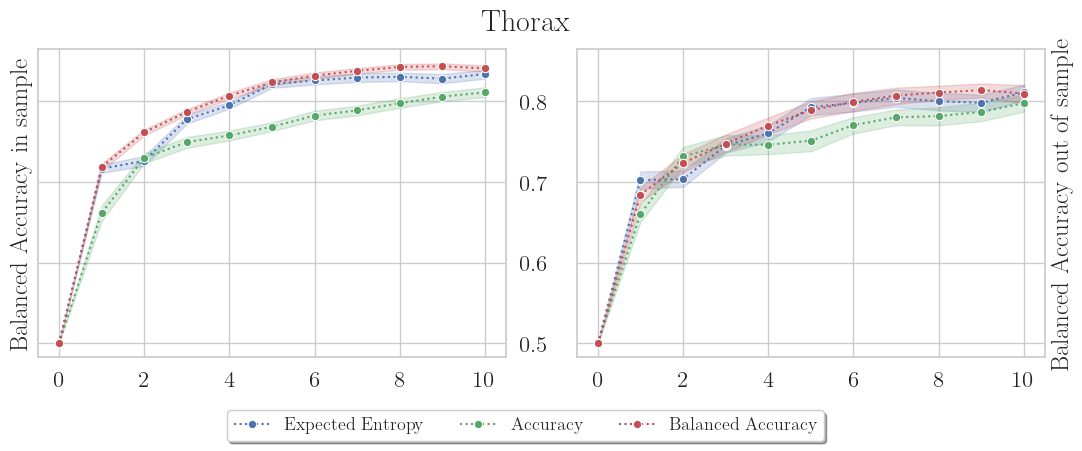

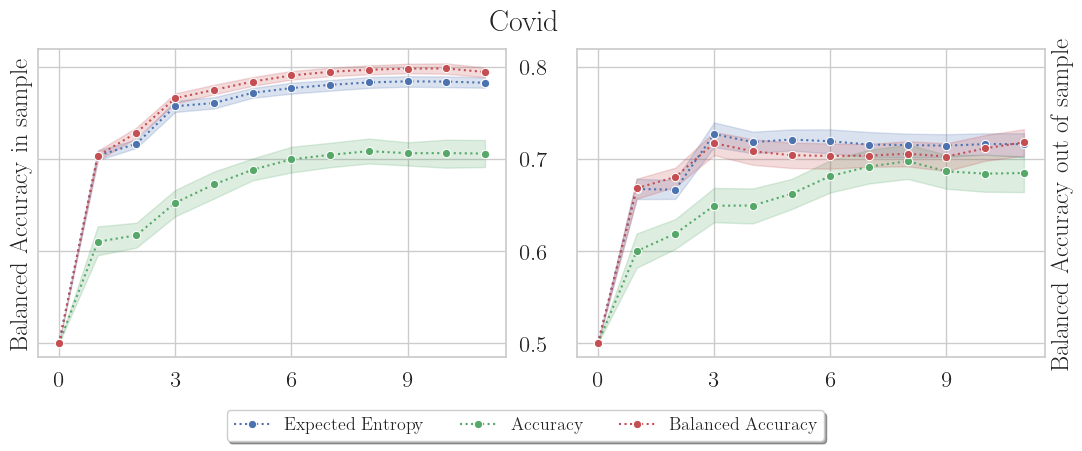

In [4]:
datasets = ["thorax", "covid"]
for dataset_name in datasets:
    fig, axes = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=.15))
    fig.set_size_inches(13,4)
    axes = np.ravel(axes)
    
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["accuracy","balanced_accuracy","expected_entropy"])
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][:-1]
    sns.lineplot(data=results_psl, x="stage", y="balanced_accuracy_score_y_bal_train", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[0], hue_order=hue_order)
    sns.lineplot(data=results_psl, x="stage", y="balanced_accuracy_score_y_bal_test", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[1], legend=False,hue_order=hue_order)
    update_axes_tuple(axes,"Balanced Accuracy")
    
    handles, previous_labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("_"," ").title() for l in previous_labels]
    handles = [handles[i] for i in [0,2,3]]
    labels = [labels[i] for i in [0,2,3]]
        
    fig.legend(handles=handles,labels=labels,loc="upper center", bbox_to_anchor=(0.5, -0.0), fontsize=13, fancybox=True, shadow=True, ncol=5)
    fig.suptitle(dataset_name.title())
    fig.savefig(f"fig/{dataset_name}_opt_method_vs_bacc.pdf", bbox_inches='tight')

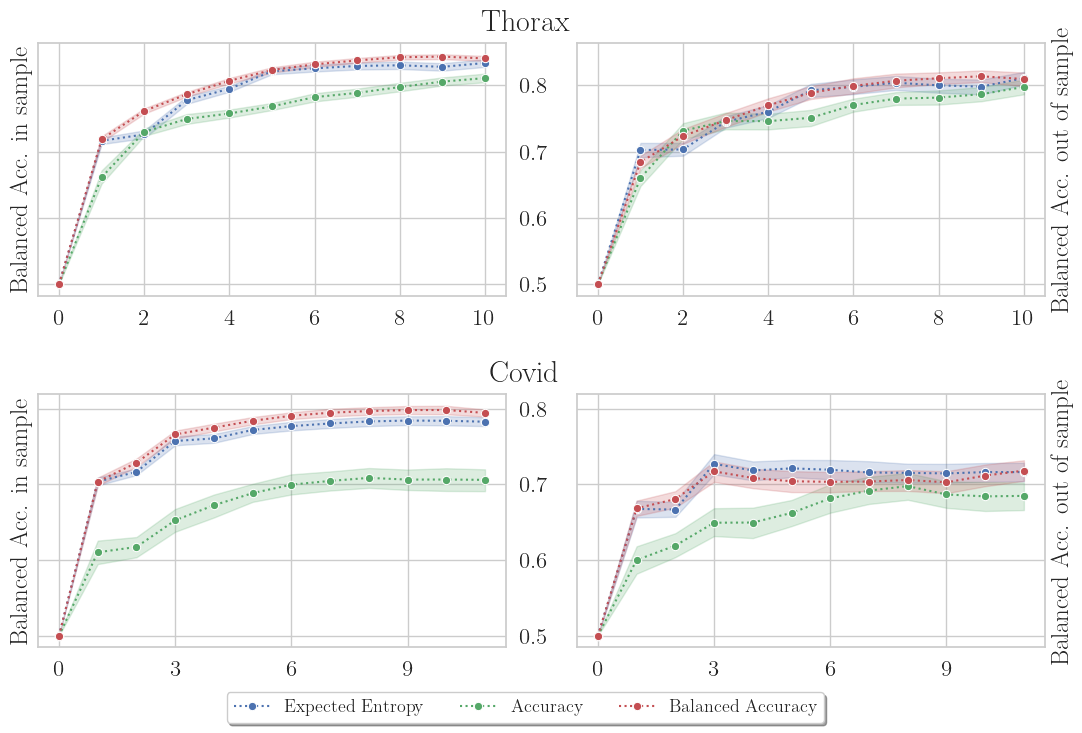

In [5]:
datasets = ["thorax", "covid"]#, "adult", "heart"]

fig = plt.figure()
fig.set_size_inches(13,3.4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

for i,dataset_name in enumerate(datasets):
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["accuracy","balanced_accuracy","expected_entropy"])
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][:-1]
    
    #metrics = ("expected_entropy" , "accuracy_score_y_pred", "constra" ,"balan", "f1")
    #not_ = ("thresh")
        
    #results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], remove_failed_runs=True, opt_crits=["expected_entropy"], suffix="features")
    #results_psl = results_psl.melt(id_vars=[ 'fold', 'method', 'score_set', 'stage', 'features', 'scores', 'c_value', 'lookahead', 
    #   'size_score_set','slim_threshold', 'solution_code',], var_name="metric", value_name="value")
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("train") &results_psl.metric.str.startswith(metrics) &~results_psl.metric.str.contains(not_) ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[0], hue_order=hue_order_train)
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("test")&results_psl.metric.str.startswith(metrics) &~results_psl.metric.str.contains(not_)  ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[1], legend=False, hue_order=hue_order_test)
    params = dict(data=results_psl, x="stage", hue="psl_optimization_metric", marker="o", linestyle=":", hue_order=hue_order)
    sns.lineplot(**params, y="balanced_accuracy_score_y_bal_train", ax=axes[0])
    sns.lineplot(**params, y="balanced_accuracy_score_y_bal_test", ax=axes[1], legend=False)
    update_axes_tuple(axes, "Balanced Acc.")

handles, labels = axes[0].get_legend_handles_labels()
# remove precision at k from legend
del handles[1]
del labels[1]
labels = [l.replace("_"," ").title() for l in labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncol=5)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/all_opt_method_vs_bacc.pdf", bbox_inches='tight')

# Optimizing Expected Entropy and evaluating CP

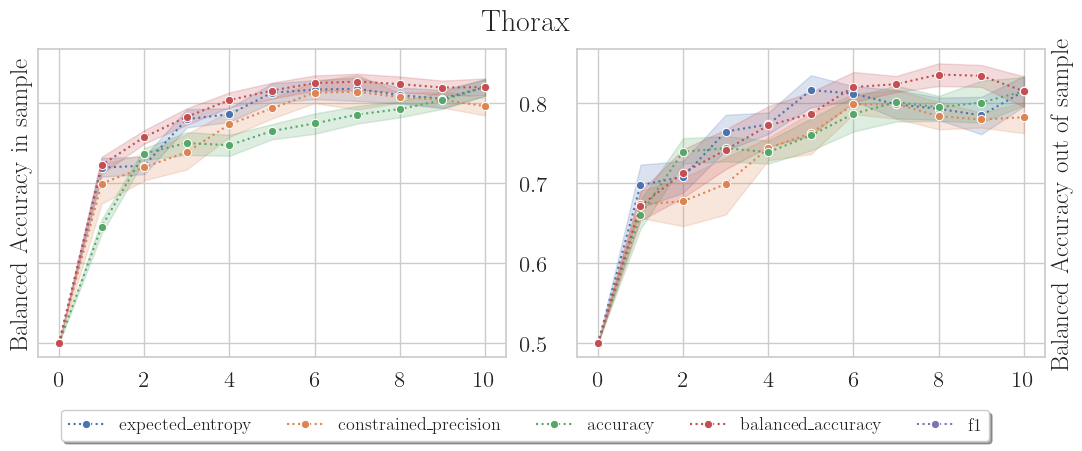

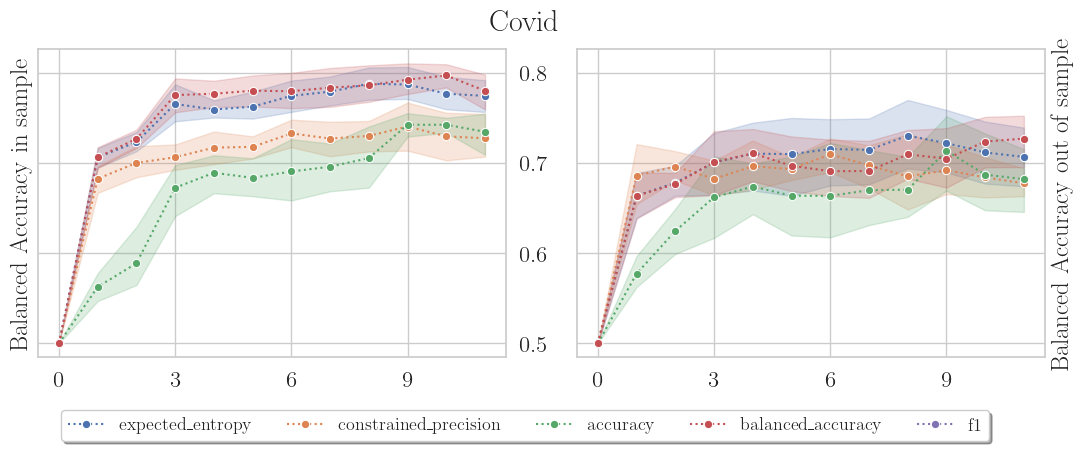

In [74]:
datasets = ["thorax", "covid"]
for dataset_name in datasets:
    fig, axes = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=.15))
    fig.set_size_inches(13,4)
    axes = np.ravel(axes)
    
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"] ,lookahead=2)
    results_psl = results_psl[results_psl.score_set_size == 2]
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train]
    sns.lineplot(data=results_psl, x="stage", y="balanced_accuracy_score_y_bal_train", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[0], hue_order=hue_order)
    sns.lineplot(data=results_psl, x="stage", y="balanced_accuracy_score_y_bal_test", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[1], legend=False,hue_order=hue_order)
    update_axes_tuple(axes,"Balanced Accuracy")
    
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
        
    fig.legend(handles=handles,labels=labels,loc="upper center", bbox_to_anchor=(0.5, -0.0), fontsize=13, fancybox=True, shadow=True, ncol=5)
    fig.suptitle(dataset_name.title())
    fig.savefig(f"fig/{dataset_name}_opt_method_vs_bacc.pdf", bbox_inches='tight')

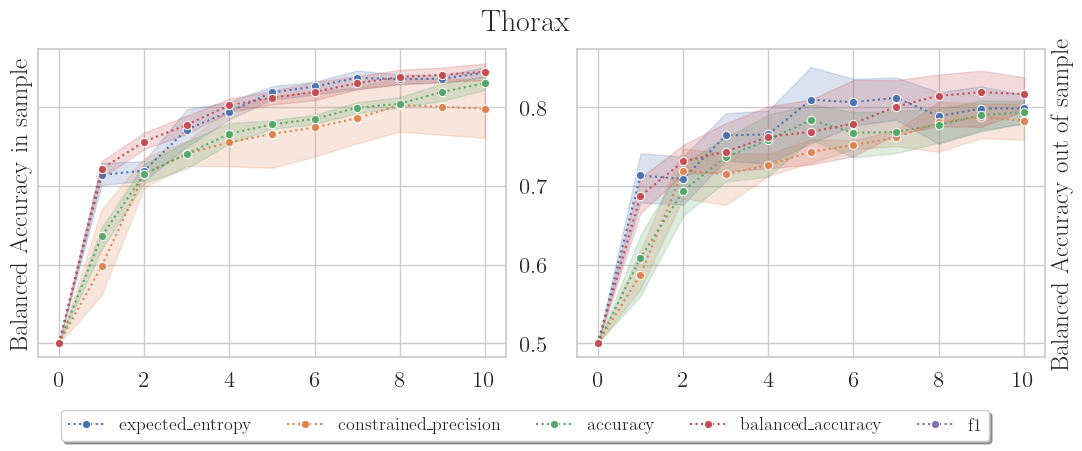

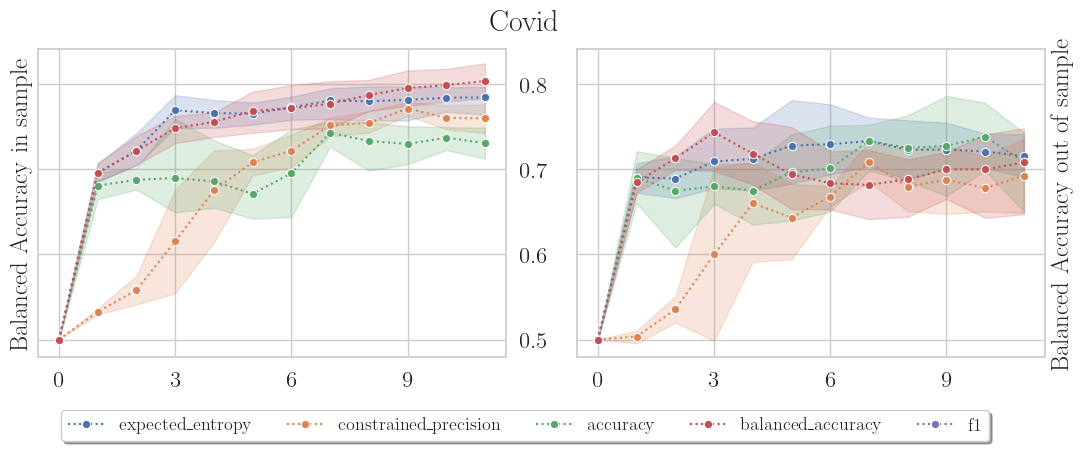

In [77]:
datasets = ["thorax", "covid"]
for dataset_name in datasets:
    fig, axes = plt.subplots(1,2, sharey=True, gridspec_kw=dict(wspace=.15))
    fig.set_size_inches(13,4)
    axes = np.ravel(axes)
    
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"] ,lookahead=1)
    results_psl = results_psl[results_psl.score_set_size == 10]
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train]
    sns.lineplot(data=results_psl, x="stage", y="balanced_accuracy_score_y_bal_train", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[0], hue_order=hue_order)
    sns.lineplot(data=results_psl, x="stage", y="balanced_accuracy_score_y_bal_test", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[1], legend=False,hue_order=hue_order)
    update_axes_tuple(axes,"Balanced Accuracy")
    
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
        
    fig.legend(handles=handles,labels=labels,loc="upper center", bbox_to_anchor=(0.5, -0.0), fontsize=13, fancybox=True, shadow=True, ncol=5)
    fig.suptitle(dataset_name.title())
    fig.savefig(f"fig/{dataset_name}_opt_method_vs_bacc.pdf", bbox_inches='tight')

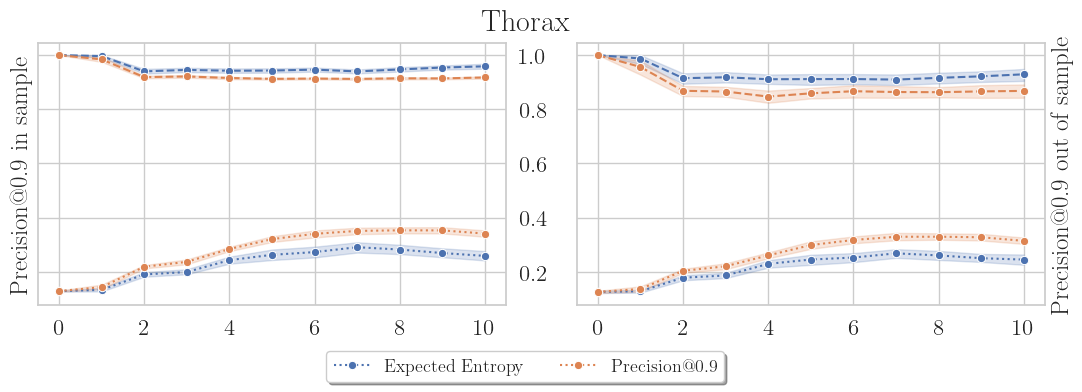

In [7]:
datasets = ["thorax"]

fig = plt.figure()
fig.set_size_inches(13,3.4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

for i,dataset_name in enumerate(datasets):
    if not hasattr(subfigs, "__len__"):
        subfigs=[subfigs]
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"])
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][0:2]
    
    #metrics = ("expected_entropy" , "accuracy_score_y_pred", "constra" ,"balan", "f1")
    #not_ = ("thresh")
        
    #results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], remove_failed_runs=True, opt_crits=["expected_entropy"], suffix="features")
    #results_psl = results_psl.melt(id_vars=[ 'fold', 'method', 'score_set', 'stage', 'features', 'scores', 'c_value', 'lookahead', 
    #   'size_score_set','slim_threshold', 'solution_code',], var_name="metric", value_name="value")
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("train") &results_psl.metric.str.startswith(metrics) &~results_psl.metric.str.contains(not_) ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[0], hue_order=hue_order_train)
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("test")&results_psl.metric.str.startswith(metrics) &~results_psl.metric.str.contains(not_)  ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[1], legend=False, hue_order=hue_order_test)
    params = dict(data=results_psl, x="stage", hue="psl_optimization_metric", marker="o", linestyle=":", hue_order=hue_order)
    sns.lineplot(**params, y="precision_score_cp_train", ax=axes[0])
    sns.lineplot(**params|dict( linestyle="--"), y="recall_score_cp_train", ax=axes[0], legend=False)
    sns.lineplot(**params, y="precision_score_cp_test", ax=axes[1], legend=False)
    sns.lineplot(**params|dict( linestyle="--"), y="recall_score_cp_test", ax=axes[1], legend=False)
    update_axes_tuple(axes, "Precision@0.9")

handles, previous_labels = axes[0].get_legend_handles_labels()
labels = [l.replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncol=5)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/all_opt_method_vs_cp.pdf", bbox_inches='tight')

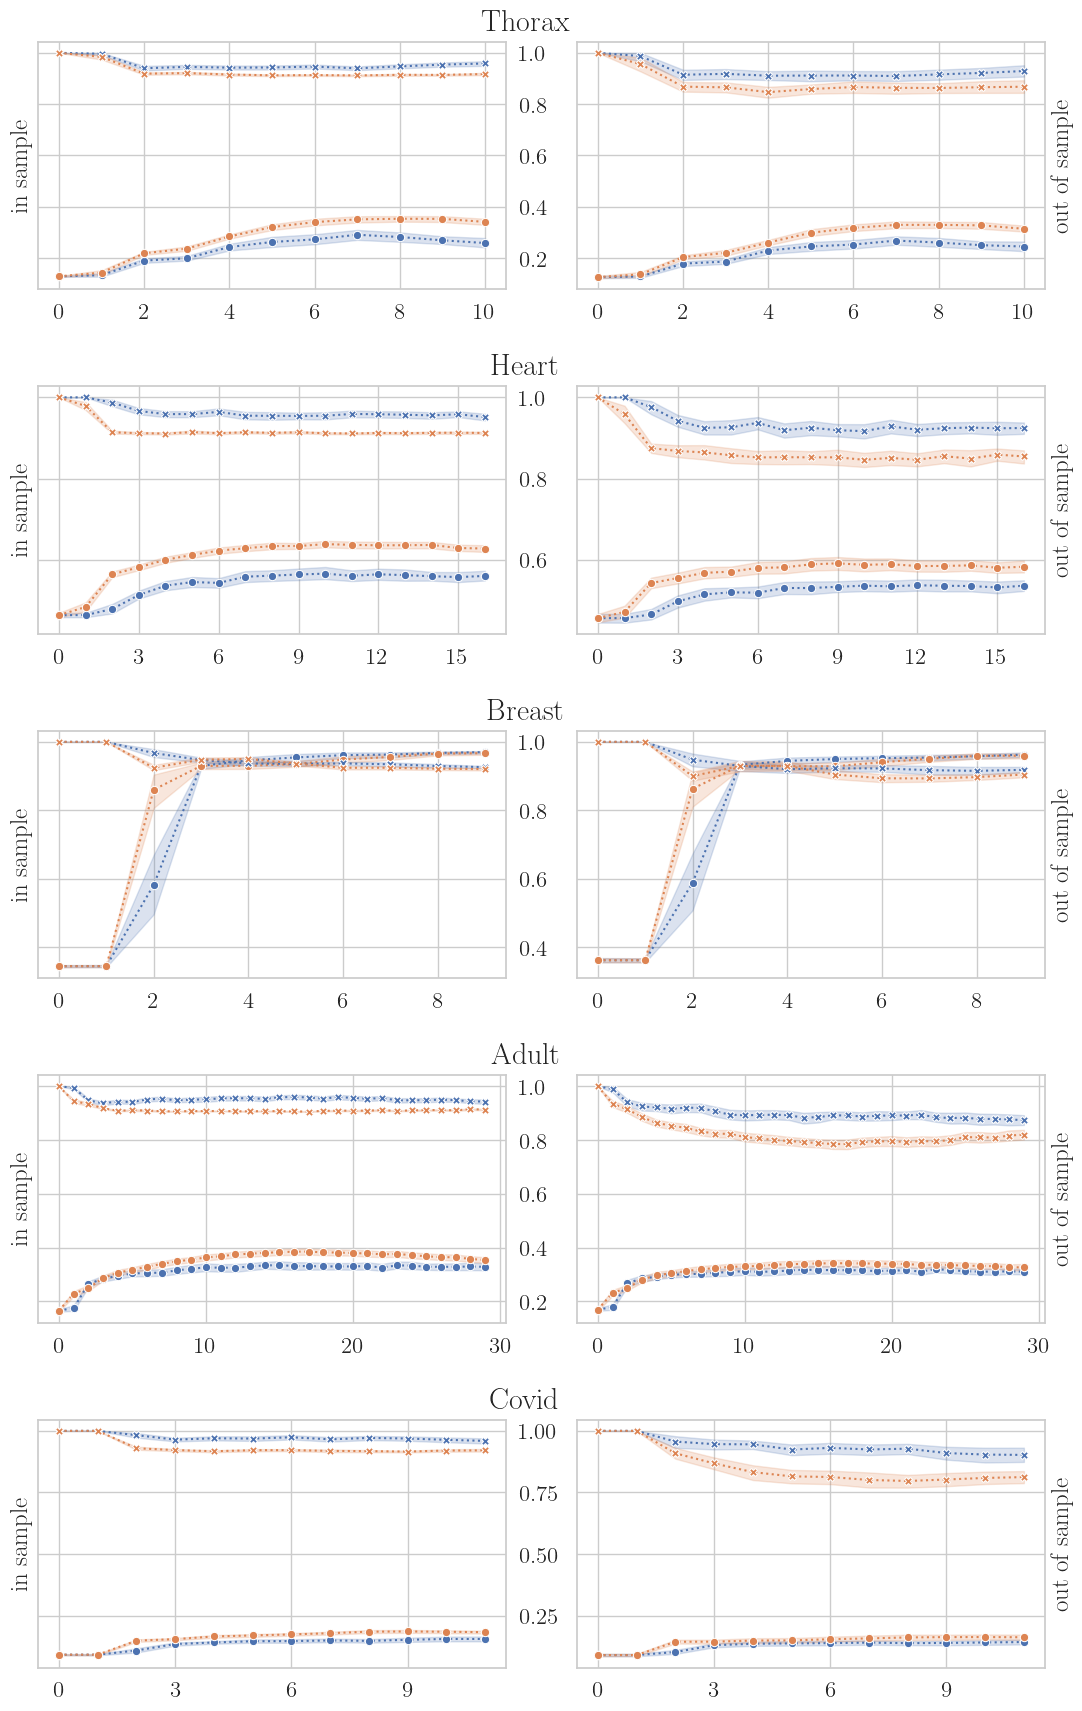

In [11]:
datasets = ["thorax", "heart", "breast","adult", "covid"]

fig = plt.figure()
fig.set_size_inches(13,3.4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

for i,dataset_name in enumerate(datasets):
    if not hasattr(subfigs, "__len__"):
        subfigs = [subfigs]
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"])
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][0:2]
    
    metrics = ("precision_score_cp" , "recall_score_cp")
    #not_ = ("thresh")
        
    #results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], remove_failed_runs=True)
    #display(results_psl.columns)
    #results_psl = results_psl.melt(id_vars=[ 'fold', 'method', 'score_set', 'stage', 'lookahead'], value_vars=["psl_optimization_metric","precision_score_cp_train"], value_name="value")
    #display(results_psl)
    #exit()
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("train") &results_psl.metric.str.startswith(metrics) ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[0], hue_order=hue_order_train[0:2])
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("test")&results_psl.metric.str.startswith(metrics)   ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[1], legend=False, hue_order=hue_order_test[0:2])
    params = dict(data=results_psl, x="stage", hue="psl_optimization_metric", marker="o", linestyle=":", hue_order=hue_order)
    sns.lineplot(**params, y="precision_score_cp_train", ax=axes[0])
    sns.lineplot(**params|dict( marker="X"), y="recall_score_cp_train", ax=axes[0], legend=True)
    sns.lineplot(**params, y="precision_score_cp_test", ax=axes[1], legend=False)
    sns.lineplot(**params|dict( marker="X"), y="recall_score_cp_test", ax=axes[1], legend=False)
    update_axes_tuple(axes, "")

handles, previous_labels = axes[0].get_legend_handles_labels()
labels = [l.replace("_train","").replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
#fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncol=5)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/all_opt_method_vs_cp.png", bbox_inches='tight')

In [ ]:
dataset_name =  "thorax"

fig = plt.figure()
fig.set_size_inches(6,3.4)
#subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.1)
fig.suptitle(dataset_name.title())
ax = fig.subplots(nrows=1, ncols=1)
metrics = ("expected_entropy" , "accuracy_score_y_pred", "constra" ,"balanced_accuracy_score_y_bal", "f1")
not_ = ("thresh")
    
results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["expected_entropy"])
results_psl = results_psl.melt(id_vars=[ 'fold', 'method', 'score_set', 'stage', 'features', 'scores', 'c_value', 'lookahead', 
   'size_score_set','slim_threshold', 'solution_code',], var_name="metric", value_name="value")
df = results_psl[results_psl.metric.str.endswith("test")&results_psl.metric.str.startswith(metrics) &~results_psl.metric.str.contains(not_)  ]
sns.lineplot(data=df, x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=ax, hue_order=hue_order_test)
ax.set_ylabel("Out of sample performance")
ax.get_legend().remove()
ax.set_xlabel("")

handles, previous_labels = ax.get_legend_handles_labels()
labels = [l.replace("_y_pred","").replace("_test", "").replace("_y_bal","").replace("_score","").replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.00), fontsize=13, fancybox=True, shadow=True, ncol=5)
plt.savefig(f"fig/thorax_opt_exp_entr_varios_metrics.pdf", bbox_inches='tight')

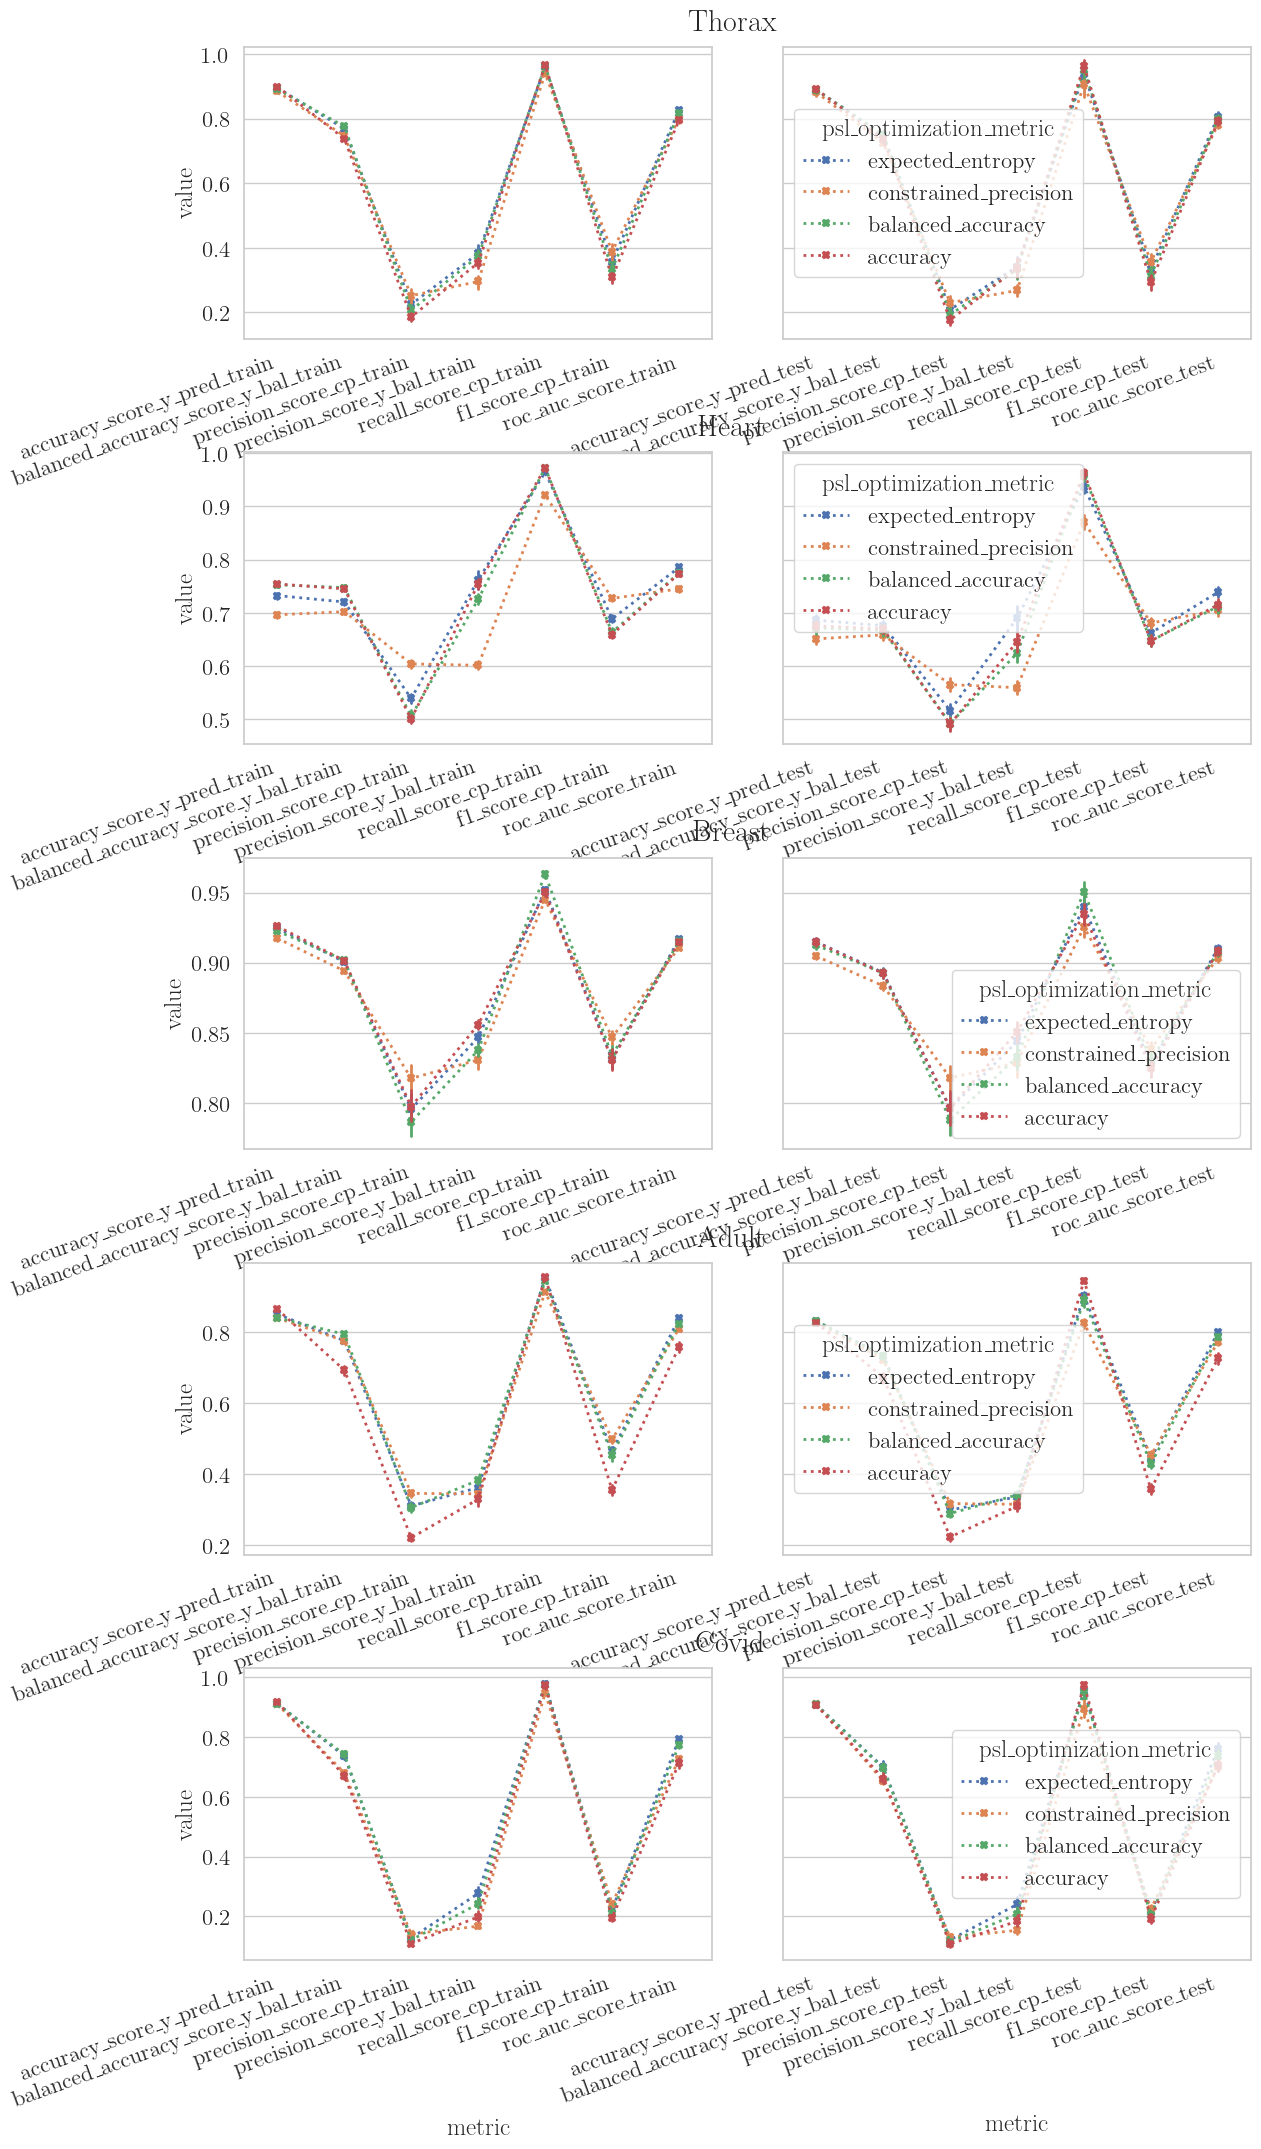

In [6]:
datasets = ["thorax", "heart", "breast","adult", "covid"]

fig = plt.figure()
fig.set_size_inches(13,4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

for i,dataset_name in enumerate(datasets):
    if not hasattr(subfigs, "__len__"):
        subfigs = [subfigs]
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"])
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][0:2]
    
    metrics = ("accuracy_score_y_pred" , "balanced_accuracy_score_y_bal", "precision_score_cp", "precision_score_y_bal", "recall_score_cp", "f1_score_cp","roc_auc_score")
    #not_ = ("thresh")
    metrics_precise = [m +"_"+ sample for sample in ["train","test"] for m in metrics]
    results_psl = results_psl.melt(id_vars=[ 'fold', 'method',  'stage', "psl_optimization_metric"], value_vars=metrics_precise, var_name="metric", value_name="value")
    results_psl = results_psl.groupby(['fold', 'method', "metric","psl_optimization_metric"],sort=False).mean(["value"]).reset_index()
    plot_params= dict(x="metric", y="value", hue="psl_optimization_metric", markers="X",linewidth=2, linestyle=":")
    sns.pointplot(data=results_psl[results_psl.metric.str.endswith("train") ], **plot_params, ax=axes[0],legend=False)#, hue_order=hue_order_train[0:2])
    sns.pointplot(data=results_psl[results_psl.metric.str.endswith("test") ], **plot_params, ax=axes[1])#, hue_order=hue_order_train[0:2])
    [plt.setp(ax.get_xticklabels(), rotation=20, ha="right") for ax in axes]
    #sns.boxplot(data=results_psl[results_psl.metric.str.endswith("train") ], x="stage", y="value", hue="psl_optimization_metric", marker="o", linestyle=":", ax=axes[0])#, hue_order=hue_order_train[0:2])
    #sns.lineplot(data=results_psl[results_psl.metric.str.endswith("test")&results_psl.metric.str.startswith(metrics)   ], x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=axes[1], legend=False, hue_order=hue_order_test[0:2])
    #params = dict(data=results_psl, x="stage", hue="psl_optimization_metric", marker="o", linestyle=":", hue_order=hue_order)
    #sns.lineplot(**params, y="precision_score_cp_train", ax=axes[0])
    #sns.lineplot(**params|dict( marker="X"), y="recall_score_cp_train", ax=axes[0], legend=True)
    #sns.lineplot(**params, y="precision_score_cp_test", ax=axes[1], legend=False)
    #sns.lineplot(**params|dict( marker="X"), y="recall_score_cp_test", ax=axes[1], legend=False)
    #update_axes_tuple(axes, "")

handles, previous_labels = axes[0].get_legend_handles_labels()
labels = [l.replace("_train","").replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
#fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncol=5)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/all_vs_all.pdf", bbox_inches='tight')

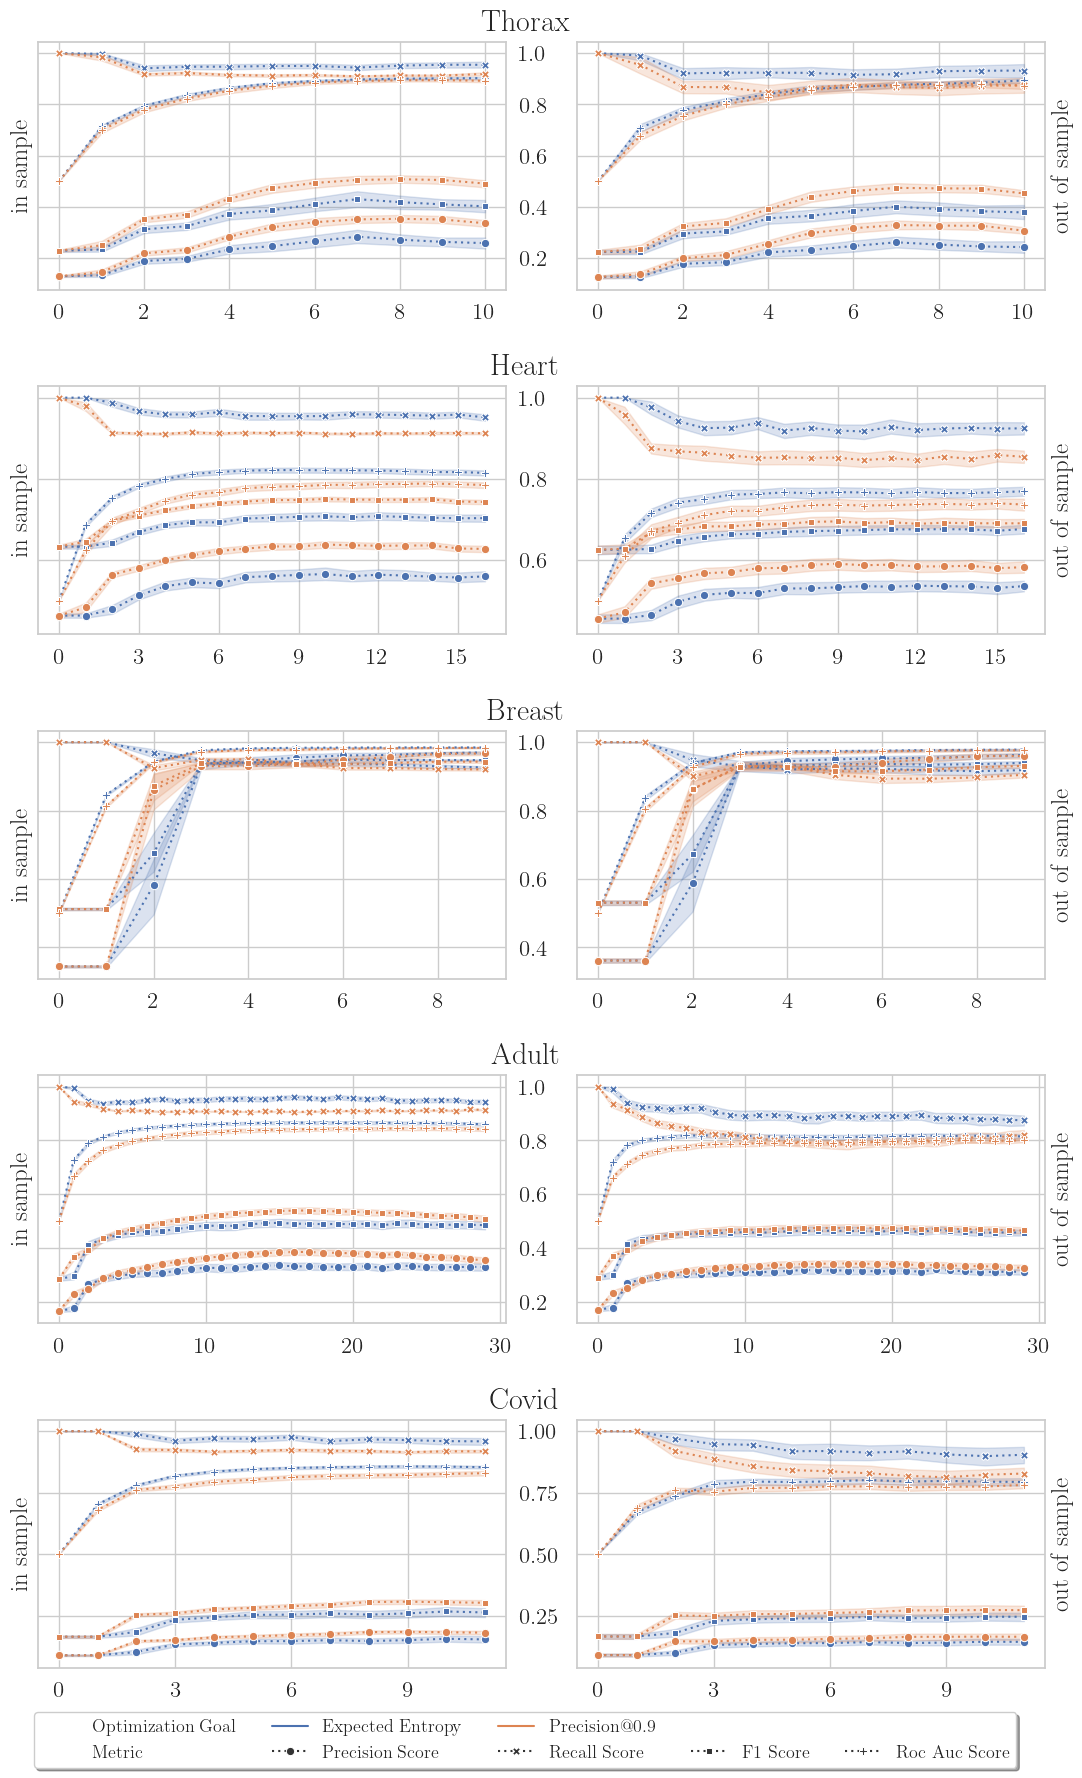

In [88]:
datasets = ["thorax", "heart", "breast","adult", "covid"]

fig = plt.figure()
fig.set_size_inches(13,3.4*len(datasets))
subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.07)

opt_crits=["expected_entropy", "constrained_precision"]
metrics = ("precision_score_cp", "recall_score_cp", "f1_score_cp", "roc_auc_score")

for i,dataset_name in enumerate(datasets):
    if not hasattr(subfigs, "__len__"):
        subfigs = [subfigs]
    subfigs[i].suptitle(dataset_name.title())
    axes = subfigs[i].subplots(nrows=1, ncols=2, sharey=True, gridspec_kw=dict(wspace=.15))
    results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=opt_crits, lookahead=2, scoreset_size=6)
    hue_order = [l.replace("_train", "").replace("_y_pred","").replace("_y_bal","").replace("_score","") for l in hue_order_train][0:2]
    
    metrics_precise = [m +"_"+ sample for sample in ["train","test"] for m in metrics]
    results_psl = results_psl.melt(id_vars=[ 'fold', 'method',  'stage', "psl_optimization_metric"], value_vars=metrics_precise, var_name="metric", value_name="value")
    #results_psl = results_psl.groupby(['fold', 'method', "metric","psl_optimization_metric"],sort=False).mean(["value"]).reset_index()
    plot_params= dict(x="stage", y="value", hue="psl_optimization_metric", style="metric", markers=True, dashes=[(1,2)]*4)
    sns.lineplot(data=results_psl[results_psl.metric.str.endswith("train") ], **plot_params, ax=axes[0])#, hue_order=hue_order_train[0:2])
    sns.lineplot(data=results_psl[results_psl.metric.str.endswith("test") ], **plot_params, ax=axes[1], legend=False)#, hue_order=hue_order_train[0:2])
    update_axes_tuple(axes, "")

handle_label_pairs = list(zip(*axes[0].get_legend_handles_labels()))
# reshape
[handle_label_pairs.insert(3,(Patch(visible=False),"")) for _ in range(len(metrics)-len(opt_crits))]
handle_label_pairs = np.array(handle_label_pairs)
handles, labels = zip(*np.transpose(a.reshape(2,-1,2), axes=[1,0,2]).reshape(-1,2).tolist())
labels = [l.replace("psl_optimization_metric","optimization_goal").replace("_cp","").replace("_train","").replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.), fontsize=13, fancybox=True, shadow=True, ncols=len(metrics)+1)
#fig.suptitle(f"Optimized for expected entropy: {dataset_name}")
plt.savefig(f"fig/optcp_optee_various_metrics.pdf", bbox_inches='tight')

In [1]:
dataset_name =  "thorax"

fig = plt.figure()
fig.set_size_inches(6,3.4)
#subfigs = fig.subfigures(nrows=len(datasets), ncols=1, hspace=.1)
fig.suptitle(dataset_name.title())
ax = fig.subplots(nrows=1, ncols=1)
metrics = ("expected_entropy" , "accuracy_score_y_pred", "constra" ,"balanced_accuracy_score_y_bal", "f1")
not_ = ("thresh")
    
results_psl = load_and_prepare_results(dataset_name=dataset_name, methods=["PSL"], opt_crits=["expected_entropy"])
results_psl = results_psl.melt(id_vars=[ 'fold', 'method', 'score_set', 'stage', 'features', 'scores', 'c_value', 'lookahead', 
   'size_score_set','slim_threshold', 'solution_code',], var_name="metric", value_name="value")
df = results_psl[results_psl.metric.str.endswith("test")&results_psl.metric.str.startswith(metrics) &~results_psl.metric.str.contains(not_)  ]
sns.lineplot(data=df, x="stage", y="value", hue="metric", marker="o", linestyle=":", ax=ax, hue_order=hue_order_test)
ax.set_ylabel("Out of sample performance")
ax.get_legend().remove()
ax.set_xlabel("")

handles, previous_labels = ax.get_legend_handles_labels()
labels = [l.replace("_y_pred","").replace("_test", "").replace("_y_bal","").replace("_score","").replace("_"," ").replace("constrained precision","Precision@0.9").title() for l in previous_labels]
fig.legend(handles=handles,labels = labels,loc="upper center", bbox_to_anchor=(0.5, -0.00), fontsize=13, fancybox=True, shadow=True, ncol=5)
plt.savefig(f"fig/thorax_opt_exp_entr_varios_metrics.pdf", bbox_inches='tight')

NameError: name 'plt' is not defined